In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

from sklearn.utils import shuffle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load data

In [3]:
df = pd.read_csv('./archive/labels_train.csv')
df = shuffle(df)
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
63619,1479498579979357100.jpg,210,222,138,148,1
6532,1478020496205554730.jpg,363,423,131,158,1
103347,1479503560316151618.jpg,211,229,137,145,1
118620,1479505029414634349.jpg,178,189,140,151,1
5541,1478020466197446152.jpg,57,106,141,160,1


In [4]:
classes = df.class_id.unique()
classes

array([1, 5, 2, 3, 4], dtype=int64)

In [5]:
object_classes = { 1: 'car', 2: 'truck', 3: 'person', 4: 'bicycle', 5: 'traffic light'}
colors = { 1: 'yellow', 2: 'red', 3: 'blue', 4: 'green', 5: 'purple'}

### Images

(6, 6)


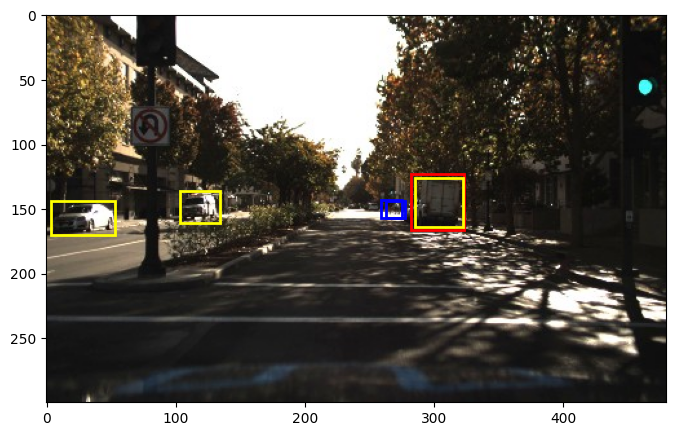

In [6]:
boxes = {}
images = {}

base_path = './archive/images/'
image_name = '1478020254691046690.jpg'
image = cv2.imread(base_path + image_name)
plt.figure(figsize = (8,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

labels = df[df['frame'] == image_name]
print(labels.shape)
for index,row in labels.iterrows():
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color = colors[row['class_id']], fill = False, linewidth = 2))
plt.show()


## Load model

In [64]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2")
])
model.build([None, 128, 128, 3])

In [3]:
detector = hub.load("https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow1/variations/openimages-v4-ssd-mobilenet-v2/versions/1")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [19]:
saved_model_path = "./model/"

loaded_model = tf.saved_model.load(saved_model_path)

In [21]:
loaded_model = tf.keras.models.load_model(saved_model_path)


### Image preprocessing

In [5]:
def process_image(image_path, img_size=224):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

### Draw boxes

In [6]:
def draw_boxes(file_path, classes, boxes, scores):
    image = cv2.imread(base_path + image_name)
    #image = image.resize((224,224))
    plt.figure(figsize = (8,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    h, w, _ = image.shape

    for i in range(0, classes.shape[0]):
        class_name = classes[i].decode('utf-8').lower()
        if(class_name in list(object_classes.values()) and scores[i] > 0.1):
            ind = [i for i in object_classes if object_classes[i] == class_name]
            print(ind)
            color = colors[ind[0]]
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            xmin = xmin * w
            xmax = xmax * w
            ymin = ymin * h
            ymax = ymax * h
            display_str = "{}: {}%".format(class_name, int(100*scores[i]))
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color = color, fill = False, linewidth = 2))
            plt.text(xmin, ymin, display_str, color=color, fontsize=12)
    plt.show()    
    

In [206]:
import keras
loaded = keras.models.load_model('Model')
class LayerFromSavedModel(tf.keras.layers.Layer):
  def __init__(self):
    super(LayerFromSavedModel, self).__init__()
    self.vars = loaded.variables
  def call(self, inputs):
    return loaded.signatures['serving_default'](inputs)

loaded.summary()
# input = tf.keras.Input(...)
# model = tf.keras.Model(input, LayerFromSavedModel()(input))
# model.save('saved_model')

AttributeError: '_UserObject' object has no attribute 'summary'

In [83]:
model = detector.signatures['default']
image_tensor = process_image(base_path + image_name)
result = model(image_tensor)


In [92]:
result.keys()

dict_keys(['detection_class_labels', 'detection_class_names', 'detection_class_entities', 'detection_boxes', 'detection_scores'])

In [96]:
result['detection_class_entities']

array([b'Tree', b'Tree', b'Car', b'Car', b'Car', b'Building', b'Tree',
       b'Person', b'Building', b'Traffic light', b'Window', b'Car',
       b'Tree', b'Tree', b'Car', b'Tree', b'Tree', b'Car', b'Tree',
       b'Car', b'Tree', b'Tree', b'Window', b'Tree', b'Window', b'Person',
       b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Tree',
       b'Window', b'Tree', b'Street light', b'Tree', b'Tree', b'Car',
       b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Window',
       b'Tree', b'Window', b'Tree', b'Building', b'Tree', b'Tree',
       b'Tree', b'Tree', b'Person', b'Tree', b'Tree', b'Tree',
       b'Street light', b'Tree', b'Tree', b'Tree', b'Tree', b'Tree',
       b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Tree', b'Wheel',
       b'Street light', b'Tree', b'Tree', b'Window', b'Tree', b'Tree',
       b'Tree', b'Building', b'Tree', b'Tree', b'Building', b'Tree',
       b'Tree', b'Tree', b'Tree', b'Street light', b'Tree', b'Window',
       b'Window', b'Tree'

In [110]:
result['detection_scores']

array([0.45054126, 0.36662003, 0.32550842, 0.27971277, 0.26980013,
       0.2120825 , 0.20155035, 0.2004128 , 0.19098382, 0.18623245,
       0.18151113, 0.18104395, 0.1784272 , 0.17219774, 0.16249429,
       0.16020773, 0.15948226, 0.15813956, 0.15796082, 0.1567619 ,
       0.15641288, 0.15534654, 0.15394065, 0.15311156, 0.15244453,
       0.15104242, 0.15077133, 0.14824653, 0.14665772, 0.14621131,
       0.14517532, 0.14498816, 0.14419763, 0.14417237, 0.1439352 ,
       0.14386778, 0.14302175, 0.14249356, 0.14187159, 0.14068528,
       0.14023912, 0.14017029, 0.13857058, 0.13849145, 0.13812982,
       0.13777688, 0.13653618, 0.13599358, 0.13585769, 0.13560487,
       0.13481118, 0.13470589, 0.13466068, 0.13348237, 0.13243802,
       0.13091186, 0.12908477, 0.12875399, 0.12730238, 0.12710376,
       0.12709925, 0.12684791, 0.12647122, 0.12602614, 0.12582675,
       0.12378015, 0.12312204, 0.12207796, 0.12200612, 0.12121531,
       0.12112926, 0.12103334, 0.12078991, 0.12048493, 0.11962

In [84]:
result = {key:value.numpy() for key,value in result.items()}
    
print("Found %d objects." % len(result["detection_scores"]))
#print("Inference time (secs): ",'{:.2}'.format(end_time-start_time))

Found 100 objects.


In [104]:
result['detection_class_names'].shape[0]

100

[1]
[1]
[1]
[3]
[5]
[1]
[1]
[1]
[1]
[3]
[1]
[3]
[5]
[1]
[1]


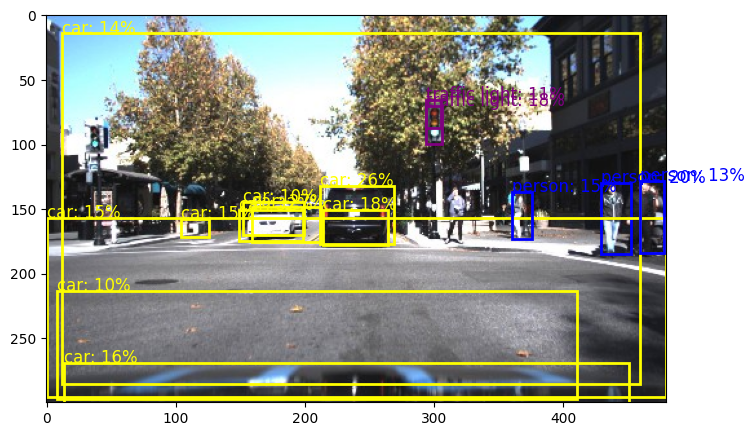

In [187]:
draw_boxes(base_path + image_name, result['detection_class_entities'], result['detection_boxes'], result['detection_scores'])